In [21]:
import matplotlib.pylab as pl
import scipy as sp
import numpy as np
from scipy.io import loadmat
import pdb

In [22]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    # extract images and labels
    imgs = data['data_patterns']
    labels = data['data_labels']
    return imgs, labels

In [23]:
def ncc_train(X, Y, Xtest, Ytest):
    # initialize accuracy vector
    acc = np.zeros(X.shape[-1])
    # unique class labels
    cids = np.unique(Y)
    # initialize mu (centroids), shape should be (256, 2) since 256 pixels, 2 classes (0 and others)
    print(X.shape[0], len(cids))
    mu = np.zeros((X.shape[0], len(cids)))
    # initialize counter Nk (number of samples per class), shape should be (2,)
    Nk = np.zeros(len(cids))
    
    # loop over all data points in training set
    for n in np.arange(X.shape[-1]):
        # set idx to current class label
        idx = np.where(cids == Y[n])[0][0]
        # update mu (centroid) by using a running mean for the current class
        mu[:, idx] = (Nk[idx] * mu[:, idx] + X[:, n]) / (Nk[idx] + 1)
        # update counter
        Nk[idx] += 1
        # predict test labels with current mu
        yhat = predict_ncc(Xtest, mu)
        # calculate current accuracy with test labels
        acc[n] = np.mean(yhat == Ytest)
    
    # return centroids (mu) and accuracy array
    return mu, acc


In [24]:
def predict_ncc(X,mu):
    # do nearest-centroid classification
    # initialize distance matrix
    NCdist = np.zeros((X.shape[-1], mu.shape[-1]))
    # compute euclidean distance to centroids
    # loop over both classes
    for ic in np.arange(mu.shape[-1]):
        # calculate distances of every point to centroid
        #
        NCdist[:,ic] = np.sqrt(np.sum((X.T - mu[:, ic].T)**2, axis=1))
        
    # assign the class label of the nearest (euclidean distance) centroid
    Yclass = NCdist.argmin(axis=1)
    return Yclass


In [25]:
digit=0

# load the data
fname = "usps.mat"
imgs,labels = load_data(fname)
# we only want to classify one digit 
labels = np.sign((labels[digit,:]>0)-.5)

# please think about what the next lines do
permidx = np.random.permutation(np.arange(imgs.shape[-1]))
trainpercent = 70.
stopat = np.floor(labels.shape[-1]*trainpercent/100.)
stopat= int(stopat)

# cut segment data into train and test set into two non-overlapping sets:
X = imgs[:, permidx[:stopat]]
Y = labels[permidx[:stopat]]
Xtest = imgs[:, permidx[stopat:]]
Ytest = labels[permidx[stopat:]]
#check that chapes of X and Y make sense..

# now comes the model estimation..
mu,acc_ncc = ncc_train(X,Y,Xtest,Ytest)


256 2


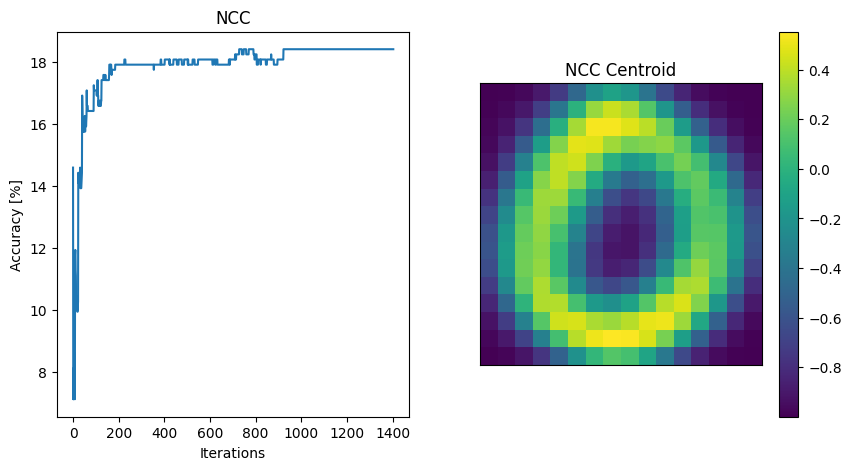

In [26]:
#save the results as a figure
fig = pl.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(acc_ncc*100.)
pl.xlabel('Iterations')
pl.title('NCC')
pl.ylabel('Accuracy [%]')

# and imshow the weight vector
ax2 = fig.add_subplot(1,2,2)
# reshape weight vector
weights = np.reshape(mu[:,-1],(int(np.sqrt(imgs.shape[0])),int(np.sqrt(imgs.shape[0]))))
# plot the weight image
imgh = ax2.imshow(weights)
# with colorbar
pl.colorbar(imgh)
ax2.set_title('NCC Centroid')
# remove axis ticks
pl.xticks(())
pl.yticks(())
# remove axis ticks
pl.xticks(())
pl.yticks(())

# write the picture to pdf
fname = 'NCC_digits-%d.pdf'%digit
pl.savefig(fname)